In [10]:
from datasets import Dataset, load_dataset, concatenate_datasets, DatasetDict
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from collections import Counter
import pandas as pd
import os
import evaluate
from scipy.special import softmax
import numpy as np
import json
ds = load_dataset("DanteZD/HC3_plus_llama70B")

In [11]:
def get_datasets(
    train_domain=None,
    train_generator=None,
    test_domain=None,
    test_generator=None,
    ratio=0.2,
    seed=None,
):
    def convert_dataset(dataset, generator):
        ds = []
        for row in dataset:
            q = row["question"]
            human = row["human_answers"]
            model = row[f"{generator}_answers"]
            for h in human[:1]:
                ds.append([q, h, 0])
            for m in model[:1]:
                ds.append([q, m, 1])

        ds = Dataset.from_pandas(pd.DataFrame(ds, columns=["question", "answer", "label"]))

        return ds
    dataset_url = "DanteZD/HC3_plus_llama70B"
    # Filter dataset based on the source
    if train_domain and train_generator:
        ds = load_dataset(dataset_url, split=train_domain)
        ds = convert_dataset(ds, train_generator)
        ds = ds.class_encode_column("label")
        ds = ds.train_test_split(test_size=ratio, seed=seed, stratify_by_column="label")
        print("Train set:")
        ds_train = ds["train"]
        print(Counter(ds_train["label"]))
        ds_val = ds["test"]
        print("Eval set")
        print(Counter(ds_val["label"]))
    else:
        ds_train = None
        ds_val = None

    if test_domain and test_generator:
        ds_test = load_dataset(dataset_url, split=test_domain)
        ds_test = convert_dataset(ds_test, test_generator)
        print("Test set:")
        print(Counter(ds_test["label"]))
    else:
        ds_test = None

    return ds_train, ds_val, ds_test

def compute_metrics(eval_preds):
    metrics = {}
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    probs = softmax(logits, axis=-1)

    roc_auc = evaluate.load("roc_auc")
    precision = evaluate.load("precision")
    recall = evaluate.load("recall")
    f1 = evaluate.load("f1")
    accuracy = evaluate.load("accuracy")

    metrics["accuracy"] = accuracy.compute(predictions=predictions, references=labels)[
        "accuracy"
    ]
    metrics["precision"] = precision.compute(
        predictions=predictions, references=labels, average=None
    )["precision"].tolist()
    metrics["recall"] = recall.compute(
        predictions=predictions, references=labels, average=None
    )["recall"].tolist()
    metrics["f1"] = f1.compute(
        predictions=predictions, references=labels, average=None
    )["f1"].tolist()
    metrics["roc_auc"] = roc_auc.compute(
        prediction_scores=probs[np.arange(len(labels)), labels], references=labels
    )["roc_auc"]
    return metrics

In [12]:
MODELNAME ="models/train_conf_reddit_train_chatgpt_head_only_True/checkpoint-200"
PAIR = False
OUT = f"models/results/{MODELNAME}"
TEST_DOMAIN = "reddit_test"
TEST_GENERATOR = "chatgpt"
SEED=42
BATCH_SIZE=8

_, _, test_dataset = get_datasets(
    test_domain=TEST_DOMAIN,
    test_generator=TEST_GENERATOR,
    ratio=0.1,
)

tokenizer = AutoTokenizer.from_pretrained(
    MODELNAME, clean_up_tokenization_spaces=True
)
kwargs = dict(max_length=512, truncation=True)
if PAIR:

    def tokenize_fn(example):
        return tokenizer(example["question"], example["answer"], **kwargs)
else:
    def tokenize_fn(example):
        return tokenizer(example["answer"], **kwargs)

print("Tokenizing and mapping...")
test_dataset = test_dataset.map(tokenize_fn)

model = AutoModelForSequenceClassification.from_pretrained(
    MODELNAME, num_labels=2
)

output_dir = OUT
os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    seed=SEED,
    per_device_eval_batch_size=BATCH_SIZE,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model,
    training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

test_results = trainer.evaluate(test_dataset)
print(test_results)
with open(output_dir + "/test_results.json", "w") as f:
    json.dump(test_results, f)


Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.2542557120323181, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.9975, 'eval_precision': [1.0, 0.9950248756218906], 'eval_recall': [0.995, 1.0], 'eval_f1': [0.9974937343358395, 0.9975062344139651], 'eval_roc_auc': 0.54051015625, 'eval_runtime': 12.9296, 'eval_samples_per_second': 123.747, 'eval_steps_per_second': 15.468}


In [23]:
import os
import json
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer, 
    DataCollatorWithPadding
)

def evaluate_model(
    modelname="models/train_conf_reddit_train_chatgpt_head_only_True/checkpoint-200",
    pair=False,
    out_dir=None,
    test_domain="reddit_test",
    test_generator="chatgpt",
    seed=42,
    batch_size=8
):
    # Prepare output directory
    if out_dir is None:
        out_dir = f"models/results/{modelname}/{test_domain}/"

    # Load dataset
    _, _, test_dataset = get_datasets(
        test_domain=test_domain,
        test_generator=test_generator,
        ratio=0.1,
    )

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        modelname, clean_up_tokenization_spaces=True
    )
    kwargs = dict(max_length=512, truncation=True)

    # Tokenization function
    if pair:
        def tokenize_fn(example):
            return tokenizer(example["question"], example["answer"], **kwargs)
    else:
        def tokenize_fn(example):
            return tokenizer(example["answer"], **kwargs)

    print("Tokenizing and mapping...")
    test_dataset = test_dataset.map(tokenize_fn)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        modelname, num_labels=2
    )

    # Create output directory if it doesn't exist
    os.makedirs(out_dir, exist_ok=True)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=out_dir,
        seed=seed,
        per_device_eval_batch_size=batch_size,
    )

    # Data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Trainer
    trainer = Trainer(
        model,
        training_args,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Evaluate and save results
    test_results = trainer.evaluate(test_dataset)
    print(test_results)
    
    with open(os.path.join(out_dir, "test_results.json"), "w") as f:
        json.dump(test_results, f)

    return test_results


In [24]:
checkpoints = ["checkpoint-200", "checkpoint-400", "checkpoint-600", "checkpoint-800",
               "checkpoint-1000", "checkpoint-1170"]
_ = [evaluate_model(
    modelname=f"models/train_conf_reddit_train_chatgpt_head_only_True/{checkpoint}",
    pair=False, out_dir=None, test_domain="reddit_test", test_generator="chatgpt",
    seed=42, batch_size=8) for checkpoint in checkpoints]
_ = [evaluate_model(
    modelname=f"models/train_conf_reddit_train_chatgpt_head_only_False/{checkpoint}",
    pair=False, out_dir=None, test_domain="reddit_test", test_generator="chatgpt",
    seed=42, batch_size=8) for checkpoint in checkpoints]
_ = [evaluate_model(
    modelname=f"models/train_conf_reddit_train_llama_head_only_True/{checkpoint}",
    pair=False, out_dir=None, test_domain="reddit_test", test_generator="llama",
    seed=42, batch_size=8) for checkpoint in checkpoints]
_ = [evaluate_model(
    modelname=f"models/train_conf_reddit_train_llama_head_only_False/{checkpoint}",
    pair=False, out_dir=None, test_domain="reddit_test", test_generator="llama",
    seed=42, batch_size=8) for checkpoint in checkpoints]

Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.2542557120323181, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.9975, 'eval_precision': [1.0, 0.9950248756218906], 'eval_recall': [0.995, 1.0], 'eval_f1': [0.9974937343358395, 0.9975062344139651], 'eval_roc_auc': 0.54051015625, 'eval_runtime': 12.2655, 'eval_samples_per_second': 130.447, 'eval_steps_per_second': 16.306}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.08793215453624725, 'eval_model_preparation_time': 0.0019, 'eval_accuracy': 0.9975, 'eval_precision': [1.0, 0.9950248756218906], 'eval_recall': [0.995, 1.0], 'eval_f1': [0.9974937343358395, 0.9975062344139651], 'eval_roc_auc': 0.813728125, 'eval_runtime': 12.1909, 'eval_samples_per_second': 131.245, 'eval_steps_per_second': 16.406}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.04589931666851044, 'eval_model_preparation_time': 0.0019, 'eval_accuracy': 0.9975, 'eval_precision': [1.0, 0.9950248756218906], 'eval_recall': [0.995, 1.0], 'eval_f1': [0.9974937343358395, 0.9975062344139651], 'eval_roc_auc': 0.71535, 'eval_runtime': 12.249, 'eval_samples_per_second': 130.623, 'eval_steps_per_second': 16.328}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.03528202697634697, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.9975, 'eval_precision': [1.0, 0.9950248756218906], 'eval_recall': [0.995, 1.0], 'eval_f1': [0.9974937343358395, 0.9975062344139651], 'eval_roc_auc': 0.8458687500000001, 'eval_runtime': 12.5268, 'eval_samples_per_second': 127.726, 'eval_steps_per_second': 15.966}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.028377514332532883, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.9975, 'eval_precision': [1.0, 0.9950248756218906], 'eval_recall': [0.995, 1.0], 'eval_f1': [0.9974937343358395, 0.9975062344139651], 'eval_roc_auc': 0.7740578125000002, 'eval_runtime': 12.7226, 'eval_samples_per_second': 125.76, 'eval_steps_per_second': 15.72}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.02737586200237274, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.9975, 'eval_precision': [1.0, 0.9950248756218906], 'eval_recall': [0.995, 1.0], 'eval_f1': [0.9974937343358395, 0.9975062344139651], 'eval_roc_auc': 0.7829203125, 'eval_runtime': 12.2943, 'eval_samples_per_second': 130.142, 'eval_steps_per_second': 16.268}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.037860121577978134, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.995625, 'eval_precision': [1.0, 0.9913258983890955], 'eval_recall': [0.99125, 1.0], 'eval_f1': [0.9956057752667922, 0.9956440572495333], 'eval_roc_auc': 0.99939453125, 'eval_runtime': 12.3972, 'eval_samples_per_second': 129.061, 'eval_steps_per_second': 16.133}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 1.3106568076182157e-05, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 1.0, 'eval_precision': [1.0, 1.0], 'eval_recall': [1.0, 1.0], 'eval_f1': [1.0, 1.0], 'eval_roc_auc': 0.0639578125, 'eval_runtime': 13.23, 'eval_samples_per_second': 120.937, 'eval_steps_per_second': 15.117}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 7.574529263365548e-06, 'eval_model_preparation_time': 0.0019, 'eval_accuracy': 1.0, 'eval_precision': [1.0, 1.0], 'eval_recall': [1.0, 1.0], 'eval_f1': [1.0, 1.0], 'eval_roc_auc': 0.003864843749999957, 'eval_runtime': 13.3634, 'eval_samples_per_second': 119.73, 'eval_steps_per_second': 14.966}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 5.848017735843314e-06, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 1.0, 'eval_precision': [1.0, 1.0], 'eval_recall': [1.0, 1.0], 'eval_f1': [1.0, 1.0], 'eval_roc_auc': 0.001725781249999963, 'eval_runtime': 12.4054, 'eval_samples_per_second': 128.976, 'eval_steps_per_second': 16.122}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 8.363462256966159e-06, 'eval_model_preparation_time': 0.0019, 'eval_accuracy': 1.0, 'eval_precision': [1.0, 1.0], 'eval_recall': [1.0, 1.0], 'eval_f1': [1.0, 1.0], 'eval_roc_auc': 0.9999546875, 'eval_runtime': 12.4775, 'eval_samples_per_second': 128.231, 'eval_steps_per_second': 16.029}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 8.943660941440612e-05, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 1.0, 'eval_precision': [1.0, 1.0], 'eval_recall': [1.0, 1.0], 'eval_f1': [1.0, 1.0], 'eval_roc_auc': 1.0, 'eval_runtime': 12.5073, 'eval_samples_per_second': 127.926, 'eval_steps_per_second': 15.991}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.2631281316280365, 'eval_model_preparation_time': 0.0021, 'eval_accuracy': 0.995, 'eval_precision': [0.995, 0.995], 'eval_recall': [0.995, 0.995], 'eval_f1': [0.995, 0.995], 'eval_roc_auc': 0.7058593749999998, 'eval_runtime': 11.8597, 'eval_samples_per_second': 134.91, 'eval_steps_per_second': 16.864}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.09195384383201599, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.995, 'eval_precision': [0.995, 0.995], 'eval_recall': [0.995, 0.995], 'eval_f1': [0.995, 0.995], 'eval_roc_auc': 0.7619546875000001, 'eval_runtime': 11.9593, 'eval_samples_per_second': 133.787, 'eval_steps_per_second': 16.723}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.05156891047954559, 'eval_model_preparation_time': 0.0019, 'eval_accuracy': 0.995, 'eval_precision': [0.995, 0.995], 'eval_recall': [0.995, 0.995], 'eval_f1': [0.995, 0.995], 'eval_roc_auc': 0.8116421875, 'eval_runtime': 11.6378, 'eval_samples_per_second': 137.483, 'eval_steps_per_second': 17.185}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.03822102025151253, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.995, 'eval_precision': [0.995, 0.995], 'eval_recall': [0.995, 0.995], 'eval_f1': [0.995, 0.995], 'eval_roc_auc': 0.83568359375, 'eval_runtime': 12.4996, 'eval_samples_per_second': 128.004, 'eval_steps_per_second': 16.0}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.035057321190834045, 'eval_model_preparation_time': 0.0019, 'eval_accuracy': 0.995, 'eval_precision': [0.995, 0.995], 'eval_recall': [0.995, 0.995], 'eval_f1': [0.995, 0.995], 'eval_roc_auc': 0.8939867187499999, 'eval_runtime': 11.8893, 'eval_samples_per_second': 134.575, 'eval_steps_per_second': 16.822}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.03278687596321106, 'eval_model_preparation_time': 0.002, 'eval_accuracy': 0.995, 'eval_precision': [0.995, 0.995], 'eval_recall': [0.995, 0.995], 'eval_f1': [0.995, 0.995], 'eval_roc_auc': 0.872384375, 'eval_runtime': 12.1641, 'eval_samples_per_second': 131.535, 'eval_steps_per_second': 16.442}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.012162742204964161, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.9975, 'eval_precision': [0.9987468671679198, 0.9962593516209476], 'eval_recall': [0.99625, 0.99875], 'eval_f1': [0.9974968710888611, 0.9975031210986267], 'eval_roc_auc': 0.9509375, 'eval_runtime': 12.3403, 'eval_samples_per_second': 129.657, 'eval_steps_per_second': 16.207}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.013537771999835968, 'eval_model_preparation_time': 0.0019, 'eval_accuracy': 0.998125, 'eval_precision': [0.9962640099626401, 1.0], 'eval_recall': [1.0, 0.99625], 'eval_f1': [0.9981285090455396, 0.9981214777708203], 'eval_roc_auc': 0.5477140625, 'eval_runtime': 12.116, 'eval_samples_per_second': 132.057, 'eval_steps_per_second': 16.507}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.0015797184314578772, 'eval_model_preparation_time': 0.0019, 'eval_accuracy': 0.999375, 'eval_precision': [0.9987515605493134, 1.0], 'eval_recall': [1.0, 0.99875], 'eval_f1': [0.9993753903810119, 0.9993746091307066], 'eval_roc_auc': 0.9937546875000001, 'eval_runtime': 12.1759, 'eval_samples_per_second': 131.407, 'eval_steps_per_second': 16.426}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.009940546937286854, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.998125, 'eval_precision': [0.9962640099626401, 1.0], 'eval_recall': [1.0, 0.99625], 'eval_f1': [0.9981285090455396, 0.9981214777708203], 'eval_roc_auc': 0.993753125, 'eval_runtime': 11.9018, 'eval_samples_per_second': 134.433, 'eval_steps_per_second': 16.804}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.008874356746673584, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.99875, 'eval_precision': [1.0, 0.9975062344139651], 'eval_recall': [0.9975, 1.0], 'eval_f1': [0.9987484355444305, 0.9987515605493134], 'eval_roc_auc': 0.9925390625, 'eval_runtime': 11.9059, 'eval_samples_per_second': 134.388, 'eval_steps_per_second': 16.798}
Test set:
Counter({0: 800, 1: 800})
Tokenizing and mapping...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'eval_loss': 0.003134902799502015, 'eval_model_preparation_time': 0.002, 'eval_accuracy': 0.999375, 'eval_precision': [1.0, 0.9987515605493134], 'eval_recall': [0.99875, 1.0], 'eval_f1': [0.9993746091307066, 0.9993753903810119], 'eval_roc_auc': 0.0029320312499999555, 'eval_runtime': 11.7808, 'eval_samples_per_second': 135.814, 'eval_steps_per_second': 16.977}


In [34]:
checkpoints = ["checkpoint-200", "checkpoint-400", "checkpoint-600", "checkpoint-800",
               "checkpoint-1000", "checkpoint-1170"]
_ = [evaluate_model(
    modelname=f"models/train_conf_reddit_train_chatgpt_head_only_True/{checkpoint}",
    pair=False, out_dir=None, test_domain="wiki_csai", test_generator="chatgpt",
    seed=42, batch_size=8) for checkpoint in checkpoints]
_ = [evaluate_model(
    modelname=f"models/train_conf_reddit_train_chatgpt_head_only_False/{checkpoint}",
    pair=False, out_dir=None, test_domain="wiki_csai", test_generator="chatgpt",
    seed=42, batch_size=8) for checkpoint in checkpoints]
_ = [evaluate_model(
    modelname=f"models/train_conf_reddit_train_llama_head_only_True/{checkpoint}",
    pair=False, out_dir=None, test_domain="wiki_csai", test_generator="llama",
    seed=42, batch_size=8) for checkpoint in checkpoints]
_ = [evaluate_model(
    modelname=f"models/train_conf_reddit_train_llama_head_only_False/{checkpoint}",
    pair=False, out_dir=None, test_domain="wiki_csai", test_generator="llama",
    seed=42, batch_size=8) for checkpoint in checkpoints]

Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 0.8626611232757568, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.4975, 'eval_precision': [0.0, 0.49874686716791977], 'eval_recall': [0.0, 0.995], 'eval_f1': [0.0, 0.664440734557596], 'eval_roc_auc': 0.999825, 'eval_runtime': 6.1231, 'eval_samples_per_second': 65.327, 'eval_steps_per_second': 8.166}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 1.3659567832946777, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.4975, 'eval_precision': [0.0, 0.49874686716791977], 'eval_recall': [0.0, 0.995], 'eval_f1': [0.0, 0.664440734557596], 'eval_roc_auc': 0.999925, 'eval_runtime': 6.2051, 'eval_samples_per_second': 64.463, 'eval_steps_per_second': 8.058}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 1.652907133102417, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.4975, 'eval_precision': [0.0, 0.49874686716791977], 'eval_recall': [0.0, 0.995], 'eval_f1': [0.0, 0.664440734557596], 'eval_roc_auc': 0.999925, 'eval_runtime': 6.1418, 'eval_samples_per_second': 65.127, 'eval_steps_per_second': 8.141}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 1.941016674041748, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.4975, 'eval_precision': [0.0, 0.49874686716791977], 'eval_recall': [0.0, 0.995], 'eval_f1': [0.0, 0.664440734557596], 'eval_roc_auc': 0.999925, 'eval_runtime': 6.1994, 'eval_samples_per_second': 64.523, 'eval_steps_per_second': 8.065}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 2.000035285949707, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.4975, 'eval_precision': [0.0, 0.49874686716791977], 'eval_recall': [0.0, 0.995], 'eval_f1': [0.0, 0.664440734557596], 'eval_roc_auc': 0.999925, 'eval_runtime': 6.2233, 'eval_samples_per_second': 64.274, 'eval_steps_per_second': 8.034}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 2.0350728034973145, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.4975, 'eval_precision': [0.0, 0.49874686716791977], 'eval_recall': [0.0, 0.995], 'eval_f1': [0.0, 0.664440734557596], 'eval_roc_auc': 0.999925, 'eval_runtime': 6.2057, 'eval_samples_per_second': 64.456, 'eval_steps_per_second': 8.057}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/home/arco/anaconda3/envs/DL4NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 5.48676872253418, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.5, 'eval_precision': [0.0, 0.5], 'eval_recall': [0.0, 1.0], 'eval_f1': [0.0, 0.6666666666666666], 'eval_roc_auc': 1.0, 'eval_runtime': 6.301, 'eval_samples_per_second': 63.482, 'eval_steps_per_second': 7.935}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 4.669860363006592, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.54, 'eval_precision': [0.9, 0.5210526315789473], 'eval_recall': [0.09, 0.99], 'eval_f1': [0.16363636363636364, 0.6827586206896552], 'eval_roc_auc': 0.988675, 'eval_runtime': 6.4046, 'eval_samples_per_second': 62.455, 'eval_steps_per_second': 7.807}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 5.716220855712891, 'eval_model_preparation_time': 0.0017, 'eval_accuracy': 0.505, 'eval_precision': [0.75, 0.5025252525252525], 'eval_recall': [0.015, 0.995], 'eval_f1': [0.029411764705882353, 0.6677852348993288], 'eval_roc_auc': 0.99585, 'eval_runtime': 6.4802, 'eval_samples_per_second': 61.726, 'eval_steps_per_second': 7.716}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 5.857205867767334, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.505, 'eval_precision': [0.75, 0.5025252525252525], 'eval_recall': [0.015, 0.995], 'eval_f1': [0.029411764705882353, 0.6677852348993288], 'eval_roc_auc': 0.99555, 'eval_runtime': 6.5684, 'eval_samples_per_second': 60.897, 'eval_steps_per_second': 7.612}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 5.859864711761475, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.5025, 'eval_precision': [0.6666666666666666, 0.5012594458438288], 'eval_recall': [0.01, 0.995], 'eval_f1': [0.019704433497536946, 0.6666666666666666], 'eval_roc_auc': 0.9999, 'eval_runtime': 6.4152, 'eval_samples_per_second': 62.352, 'eval_steps_per_second': 7.794}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 5.865478038787842, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.5, 'eval_precision': [0.5, 0.5], 'eval_recall': [0.005, 0.995], 'eval_f1': [0.009900990099009901, 0.6655518394648829], 'eval_roc_auc': 0.999975, 'eval_runtime': 6.5113, 'eval_samples_per_second': 61.432, 'eval_steps_per_second': 7.679}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/home/arco/anaconda3/envs/DL4NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.8238146901130676, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.5, 'eval_precision': [0.0, 0.5], 'eval_recall': [0.0, 1.0], 'eval_f1': [0.0, 0.6666666666666666], 'eval_roc_auc': 1.0, 'eval_runtime': 6.3955, 'eval_samples_per_second': 62.544, 'eval_steps_per_second': 7.818}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/home/arco/anaconda3/envs/DL4NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.210828423500061, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.5, 'eval_precision': [0.0, 0.5], 'eval_recall': [0.0, 1.0], 'eval_f1': [0.0, 0.6666666666666666], 'eval_roc_auc': 1.0, 'eval_runtime': 6.3302, 'eval_samples_per_second': 63.189, 'eval_steps_per_second': 7.899}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/home/arco/anaconda3/envs/DL4NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.5363519191741943, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.5, 'eval_precision': [0.0, 0.5], 'eval_recall': [0.0, 1.0], 'eval_f1': [0.0, 0.6666666666666666], 'eval_roc_auc': 1.0, 'eval_runtime': 6.1471, 'eval_samples_per_second': 65.071, 'eval_steps_per_second': 8.134}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/home/arco/anaconda3/envs/DL4NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.7478172779083252, 'eval_model_preparation_time': 0.0017, 'eval_accuracy': 0.5, 'eval_precision': [0.0, 0.5], 'eval_recall': [0.0, 1.0], 'eval_f1': [0.0, 0.6666666666666666], 'eval_roc_auc': 1.0, 'eval_runtime': 6.2837, 'eval_samples_per_second': 63.657, 'eval_steps_per_second': 7.957}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/home/arco/anaconda3/envs/DL4NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.915955662727356, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.5, 'eval_precision': [0.0, 0.5], 'eval_recall': [0.0, 1.0], 'eval_f1': [0.0, 0.6666666666666666], 'eval_roc_auc': 1.0, 'eval_runtime': 6.2645, 'eval_samples_per_second': 63.852, 'eval_steps_per_second': 7.981}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/home/arco/anaconda3/envs/DL4NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.9167007207870483, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.5, 'eval_precision': [0.0, 0.5], 'eval_recall': [0.0, 1.0], 'eval_f1': [0.0, 0.6666666666666666], 'eval_roc_auc': 1.0, 'eval_runtime': 6.2228, 'eval_samples_per_second': 64.279, 'eval_steps_per_second': 8.035}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 5.208725452423096, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.505, 'eval_precision': [1.0, 0.5025125628140703], 'eval_recall': [0.01, 1.0], 'eval_f1': [0.019801980198019802, 0.6688963210702341], 'eval_roc_auc': 1.0, 'eval_runtime': 6.3063, 'eval_samples_per_second': 63.428, 'eval_steps_per_second': 7.929}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 5.238853931427002, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.5025, 'eval_precision': [1.0, 0.5012531328320802], 'eval_recall': [0.005, 1.0], 'eval_f1': [0.009950248756218905, 0.667779632721202], 'eval_roc_auc': 0.9975625, 'eval_runtime': 6.2906, 'eval_samples_per_second': 63.587, 'eval_steps_per_second': 7.948}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 6.127509117126465, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.5025, 'eval_precision': [1.0, 0.5012531328320802], 'eval_recall': [0.005, 1.0], 'eval_f1': [0.009950248756218905, 0.667779632721202], 'eval_roc_auc': 1.0, 'eval_runtime': 6.2567, 'eval_samples_per_second': 63.932, 'eval_steps_per_second': 7.991}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 6.194890022277832, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.5025, 'eval_precision': [1.0, 0.5012531328320802], 'eval_recall': [0.005, 1.0], 'eval_f1': [0.009950248756218905, 0.667779632721202], 'eval_roc_auc': 1.0, 'eval_runtime': 6.3096, 'eval_samples_per_second': 63.396, 'eval_steps_per_second': 7.924}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 6.275071620941162, 'eval_model_preparation_time': 0.0018, 'eval_accuracy': 0.5025, 'eval_precision': [1.0, 0.5012531328320802], 'eval_recall': [0.005, 1.0], 'eval_f1': [0.009950248756218905, 0.667779632721202], 'eval_roc_auc': 1.0, 'eval_runtime': 6.3429, 'eval_samples_per_second': 63.063, 'eval_steps_per_second': 7.883}
Test set:
Counter({0: 200, 1: 200})
Tokenizing and mapping...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'eval_loss': 5.698710918426514, 'eval_model_preparation_time': 0.0019, 'eval_accuracy': 0.5025, 'eval_precision': [1.0, 0.5012531328320802], 'eval_recall': [0.005, 1.0], 'eval_f1': [0.009950248756218905, 0.667779632721202], 'eval_roc_auc': 1.0, 'eval_runtime': 6.1806, 'eval_samples_per_second': 64.719, 'eval_steps_per_second': 8.09}


In [ ]:
checkpoints = ["checkpoint-200", "checkpoint-400", "checkpoint-600", "checkpoint-800",
               "checkpoint-1000", "checkpoint-1170"]
_ = [evaluate_model(
    modelname=f"models/train_conf_reddit_train_chatgpt_head_only_True/{checkpoint}",
    pair=False, out_dir=None, test_domain="wiki_csai", test_generator="chatgpt",
    seed=42, batch_size=8) for checkpoint in checkpoints]
_ = [evaluate_model(
    modelname=f"models/train_conf_reddit_train_chatgpt_head_only_False/{checkpoint}",
    pair=False, out_dir=None, test_domain="wiki_csai", test_generator="chatgpt",
    seed=42, batch_size=8) for checkpoint in checkpoints]
_ = [evaluate_model(
    modelname=f"models/train_conf_reddit_train_llama_head_only_True/{checkpoint}",
    pair=False, out_dir=None, test_domain="wiki_csai", test_generator="llama",
    seed=42, batch_size=8) for checkpoint in checkpoints]
_ = [evaluate_model(
    modelname=f"models/train_conf_reddit_train_llama_head_only_False/{checkpoint}",
    pair=False, out_dir=None, test_domain="wiki_csai", test_generator="llama",
    seed=42, batch_size=8) for checkpoint in checkpoints]

In [35]:
def get_results(name="train_conf_reddit_train_chatgpt_head_only_False", 
                domain="reddit_test",
                checkpoint="checkpoint-200"):
    with open(f"models/results/models/{name}/{checkpoint}/{domain}/test_results.json", "r") as f:
        return json.load(f)
    

In [71]:
results_reddit_train_chatgpt_head_only_False = [get_results(name="train_conf_reddit_train_chatgpt_head_only_False", domain="reddit_test", checkpoint=checkpoint) for checkpoint in checkpoints]
results_reddit_train_chatgpt_head_only_True = [get_results(name="train_conf_reddit_train_chatgpt_head_only_True", domain="reddit_test", checkpoint=checkpoint) for checkpoint in checkpoints]
results_reddit_train_llama_head_only_False = [get_results(name="train_conf_reddit_train_llama_head_only_False", domain="reddit_test", checkpoint=checkpoint) for checkpoint in checkpoints]
results_reddit_train_llama_head_only_True = [get_results(name="train_conf_reddit_train_llama_head_only_True", domain="reddit_test", checkpoint=checkpoint) for checkpoint in checkpoints]

results_wiki_csai_train_chatgpt_head_only_False = [get_results(name="train_conf_reddit_train_chatgpt_head_only_False", domain="non_reddit_test", checkpoint=checkpoint) for checkpoint in checkpoints]
results_wiki_csai_train_chatgpt_head_only_True = [get_results(name="train_conf_reddit_train_chatgpt_head_only_True", domain="non_reddit_test", checkpoint=checkpoint) for checkpoint in checkpoints]
results_wiki_csai_train_llama_head_only_False = [get_results(name="train_conf_reddit_train_llama_head_only_False", domain="non_reddit_test", checkpoint=checkpoint) for checkpoint in checkpoints]
results_wiki_csai_train_llama_head_only_True = [get_results(name="train_conf_reddit_train_llama_head_only_True", domain="non_reddit_test", checkpoint=checkpoint) for checkpoint in checkpoints]


FileNotFoundError: [Errno 2] No such file or directory: 'models/results/models/train_conf_reddit_train_chatgpt_head_only_False/checkpoint-200/non_reddit_test/test_results.json'

[[0.995625 1.       1.       1.       1.       1.      ]
 [0.9975   0.9975   0.9975   0.9975   0.9975   0.9975  ]
 [0.9975   0.998125 0.999375 0.998125 0.99875  0.999375]
 [0.995    0.995    0.995    0.995    0.995    0.995   ]] [[0.5    0.54   0.505  0.505  0.5025 0.5   ]
 [0.4975 0.4975 0.4975 0.4975 0.4975 0.4975]
 [0.505  0.5025 0.5025 0.5025 0.5025 0.5025]
 [0.5    0.5    0.5    0.5    0.5    0.5   ]]


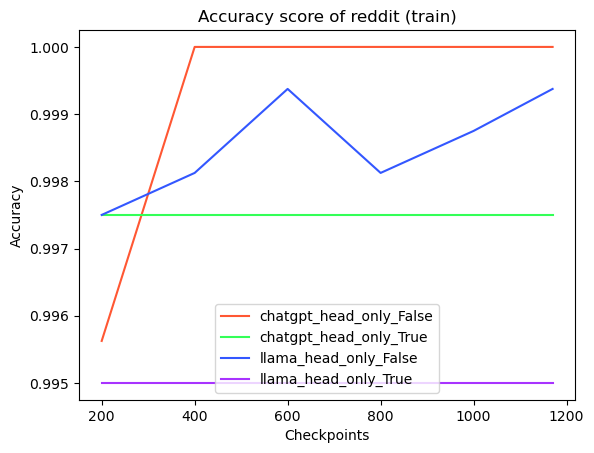

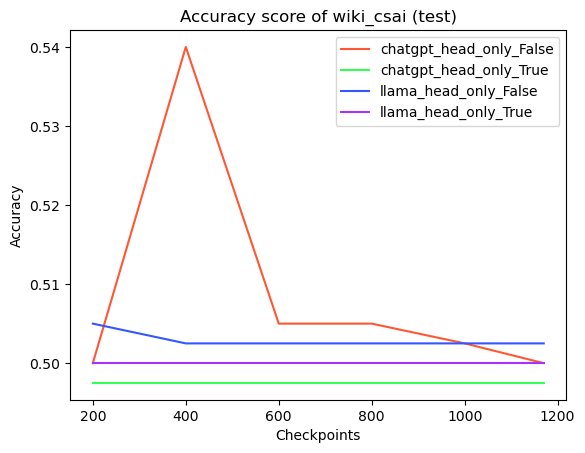

In [72]:
import matplotlib.pyplot as plt

reddit_test    = [results_reddit_train_chatgpt_head_only_False, 
                  results_reddit_train_chatgpt_head_only_True,
                  results_reddit_train_llama_head_only_False,
                  results_reddit_train_llama_head_only_True]
wiki_csai_test = [results_wiki_csai_train_chatgpt_head_only_False,
                  results_wiki_csai_train_chatgpt_head_only_True,
                  results_wiki_csai_train_llama_head_only_False,
                  results_wiki_csai_train_llama_head_only_True]

labels_reddit = ["chatgpt_head_only_False", 
                  "chatgpt_head_only_True",
                  "llama_head_only_False",
                  "llama_head_only_True"]

labels_wiki = ["chatgpt_head_only_False",
                  "chatgpt_head_only_True",
                  "llama_head_only_False",
                  "llama_head_only_True"]

checkpoints_n = [200, 400, 600, 800, 1000, 1170]
colors = ["#FF5733", "#33FF57", "#3357FF", "#A833FF"]

accuracies_wiki_csai = []
for t in wiki_csai_test:
    accuracies_wiki_csai.append([t[i]["eval_accuracy"] for i in range(6)])
accuracies_wiki_csai = np.array(accuracies_wiki_csai)

accuracies_reddit = []
for t in reddit_test:
    accuracies_reddit.append([t[i]["eval_accuracy"] for i in range(6)])
accuracies_reddit = np.array(accuracies_reddit)

print(accuracies_reddit, accuracies_wiki_csai)

# Plot reddit
plt.figure()
[plt.plot(checkpoints_n, acc, label=labels_reddit[i], color=colors[i]) for i, acc in enumerate(accuracies_reddit)]
plt.legend()
plt.title("Accuracy score of reddit (train)")
plt.xlabel("Checkpoints")
plt.ylabel("Accuracy")
plt.show()

plt.figure()  # Create a new figure
# [plt.plot(checkpoints_n, acc, label=labels_wiki[i], color=colors[i]) for i, acc in enumerate(accuracies_wiki_csai)]
plt.plot(checkpoints_n, accuracies_wiki_csai[0], label=labels_wiki[0], color=colors[0])
plt.plot(checkpoints_n, accuracies_wiki_csai[1], label=labels_wiki[1], color=colors[1])
plt.plot(checkpoints_n, accuracies_wiki_csai[2], label=labels_wiki[2], color=colors[2])
plt.plot(checkpoints_n, accuracies_wiki_csai[3], label=labels_wiki[3], color=colors[3])
plt.legend()
plt.title("Accuracy score of wiki_csai (test)")
plt.xlabel("Checkpoints")
plt.ylabel("Accuracy")
plt.show()

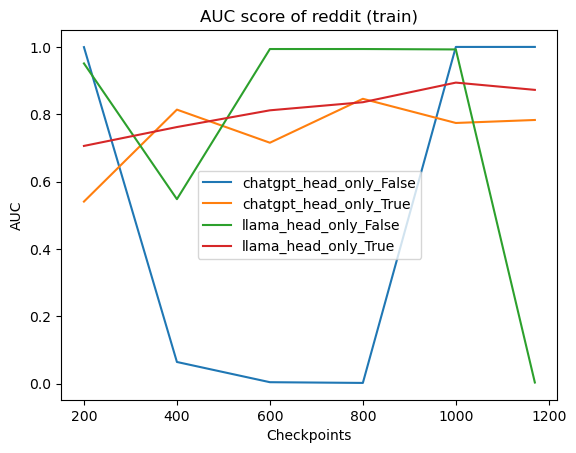

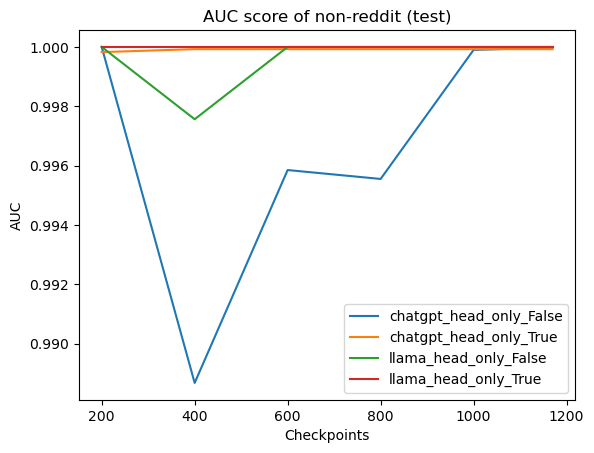

In [77]:
auc_wiki_csai = []
for t in wiki_csai_test:
    auc_wiki_csai.append([t[i]["eval_roc_auc"] for i in range(6)])
auc_wiki_csai = np.array(auc_wiki_csai)

auc_reddit = []
for t in reddit_test:
    auc_reddit.append([t[i]["eval_roc_auc"] for i in range(6)])
auc_reddit = np.array(auc_reddit)

[plt.plot(checkpoints_n, acc, label=labels_reddit[i]) for i, acc in enumerate(auc_reddit)]
plt.legend()
plt.title("AUC score of reddit (train)")
plt.xlabel("Checkpoints")
plt.ylabel("AUC")
plt.show()

[plt.plot(checkpoints_n, acc, label=labels_wiki[i]) for i, acc in enumerate(auc_wiki_csai)]
plt.legend()
plt.title("AUC score of non-reddit (test)")
plt.xlabel("Checkpoints")
plt.ylabel("AUC")
plt.show()

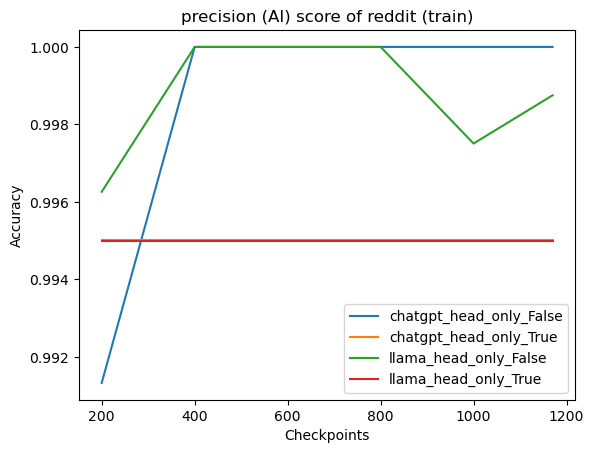

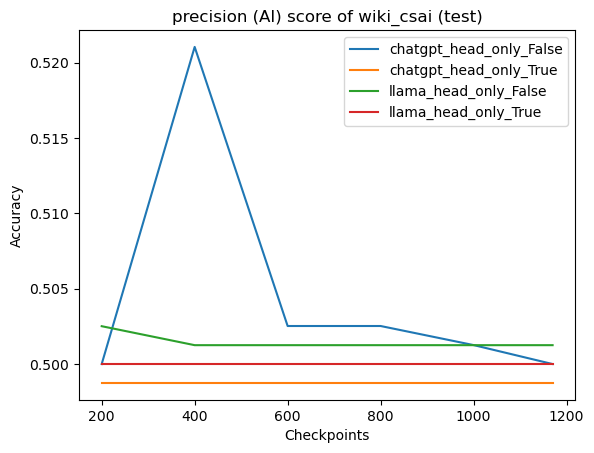

In [76]:
auc_wiki_csai = []
for t in wiki_csai_test:
    auc_wiki_csai.append([t[i]["eval_precision"][1] for i in range(6)])
auc_wiki_csai = np.array(auc_wiki_csai)

auc_reddit = []
for t in reddit_test:
    auc_reddit.append([t[i]["eval_precision"][1] for i in range(6)])
auc_reddit = np.array(auc_reddit)

[plt.plot(checkpoints_n, acc, label=labels_reddit[i]) for i, acc in enumerate(auc_reddit)]
plt.legend()
plt.title("precision (AI) score of reddit (train)")
plt.xlabel("Checkpoints")
plt.ylabel("precision")
plt.show()

[plt.plot(checkpoints_n, acc, label=labels_wiki[i]) for i, acc in enumerate(auc_wiki_csai)]
plt.legend()
plt.title("precision (AI) score of non-reddit (test)")
plt.xlabel("Checkpoints")
plt.ylabel("precision")
plt.show()